Making predictions:   0%|          | 0/500 [00:00<?, ?it/s]

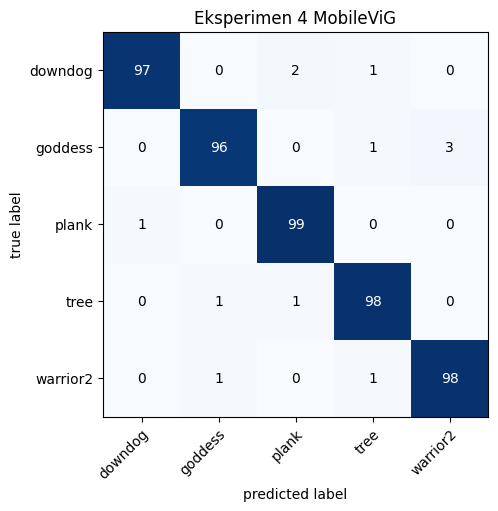

In [36]:
# import model_vig

import model_mobile_vig
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from tqdm.auto import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

torch.cuda.empty_cache()

test_dir = Path("./data/eksperimen-3/test/")
model_path = Path("./models/eksperimen_4_mobile_vig.pth")
checkpoint = torch.load(model_path)
state_dict = checkpoint["model_state_dict"]
class_names = ["downdog", "goddess", "plank", "tree", "warrior2"]
model = model_mobile_vig.mobilevig_ti(num_classes=len(class_names)).to(device)
# model = model_vig.vig_ti_224_gelu(num_classes=len(class_names)).to(device)
model.load_state_dict(state_dict=state_dict)
test_preprpocess = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((224, 224)),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_preprpocess)
class_names = test_dataset.classes
NUM_WORKERS = 4
BATCH_SIZE = 1
test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)
y_preds = []
wrong_preds = []
false_negatives = {class_name: [] for class_name in class_names}
false_positives = {class_name: [] for class_name in class_names}
model.eval()
with torch.inference_mode():
    for idx, (X, y) in enumerate(tqdm(test_dataloader, desc="Making predictions")):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_prob = torch.softmax(y_logit, dim=1)
        y_pred = y_prob.argmax(dim=1)
        y_preds.append(y_pred.cpu())
        if y_pred != y:
            image_path = test_dataset.imgs[idx][0]
            wrong_preds.append((image_path, y.cpu().item(), y_pred.cpu().item()))
            if len(false_negatives[class_names[y.cpu().item()]]) < 3:
                false_negatives[class_names[y.cpu().item()]].append(
                    (
                        image_path,
                        class_names[y.cpu().item()],
                        class_names[y_pred.cpu().item()],
                        torch.max(y_prob).item(),
                    )
                )
            if len(false_positives[class_names[y_pred.cpu().item()]]) < 3:
                false_positives[class_names[y_pred.cpu().item()]].append(
                    (
                        image_path,
                        class_names[y.cpu().item()],
                        class_names[y_pred.cpu().item()],
                        torch.max(y_prob).item(),
                    )
                )

y_pred_tensor = torch.cat(y_preds)
target_tensor = torch.tensor(test_dataset.targets)
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=target_tensor)
confmat_numpy = confmat_tensor.numpy()

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_numpy,
    class_names=class_names,
    figsize=(5, 5),
    title="Eksperimen 4 MobileViG",
)

Class: downdog


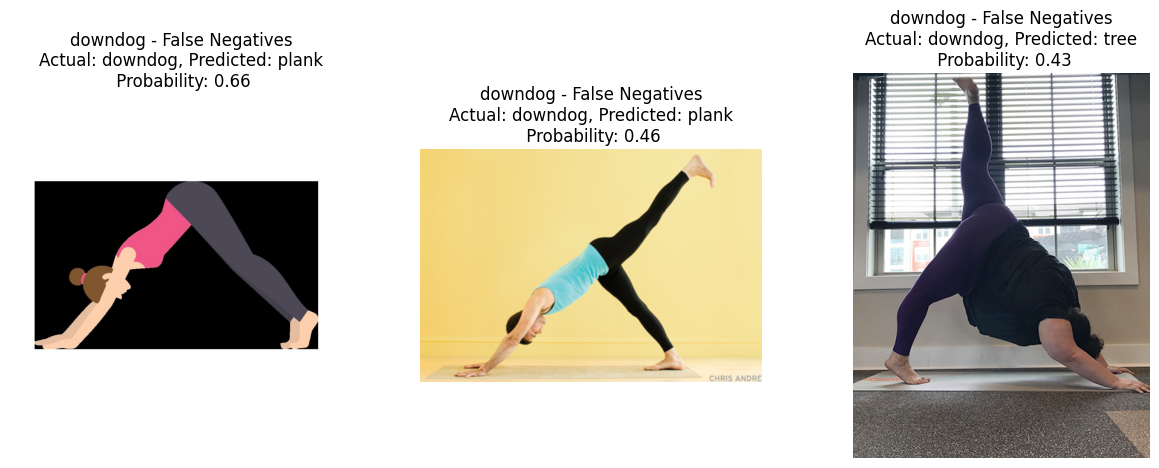

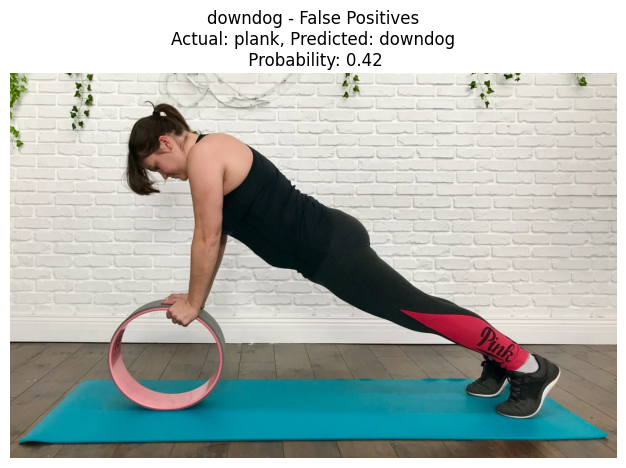

Class: goddess


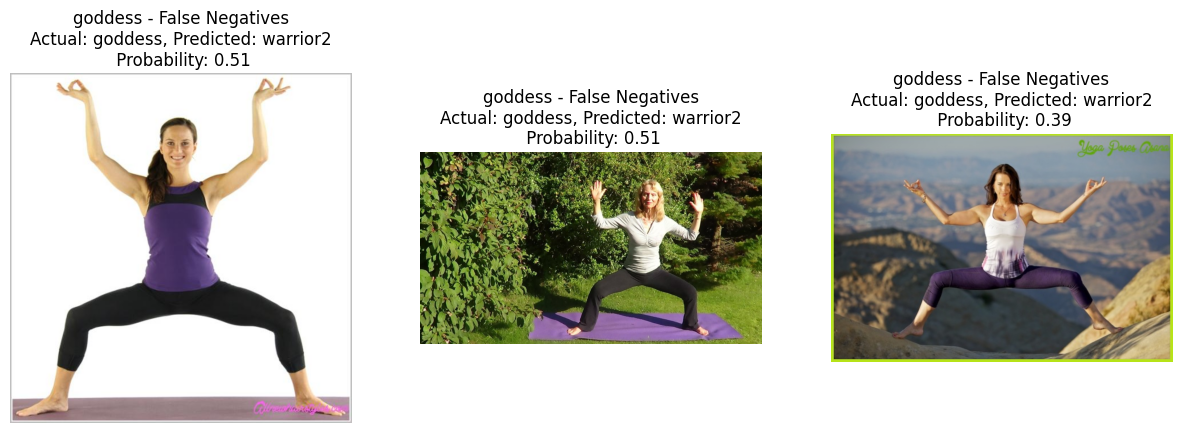

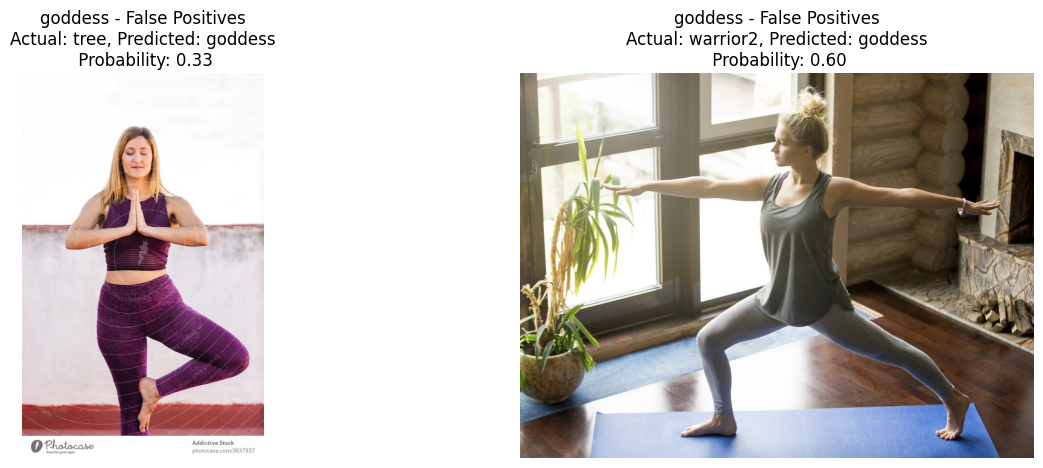

Class: plank


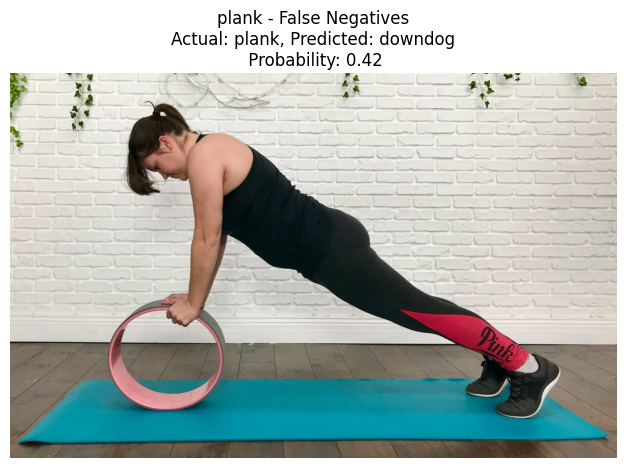

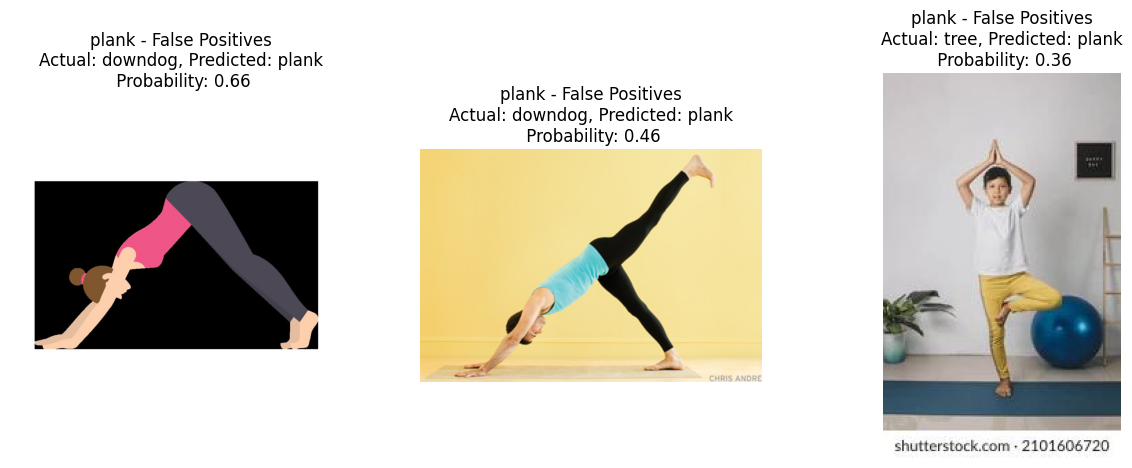

Class: tree


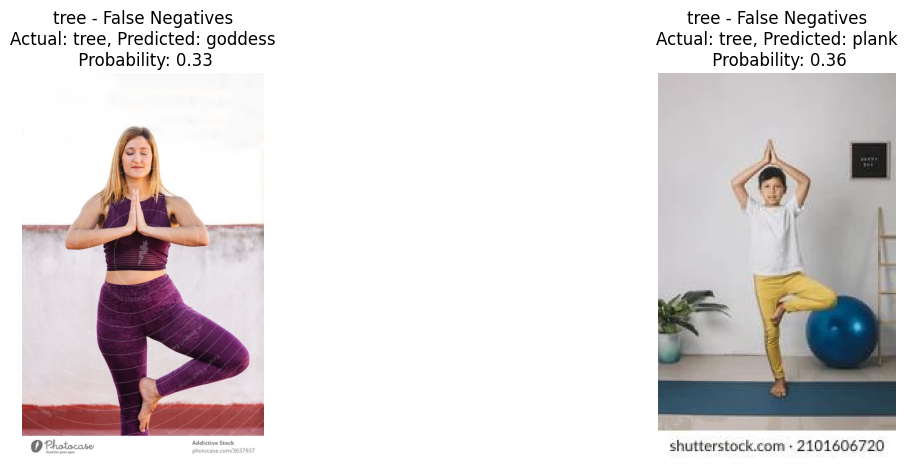

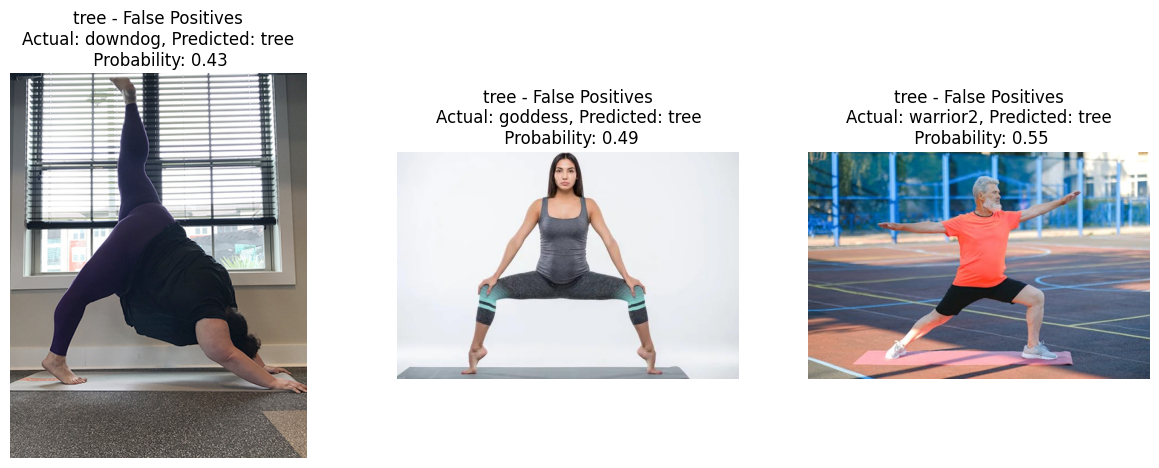

Class: warrior2


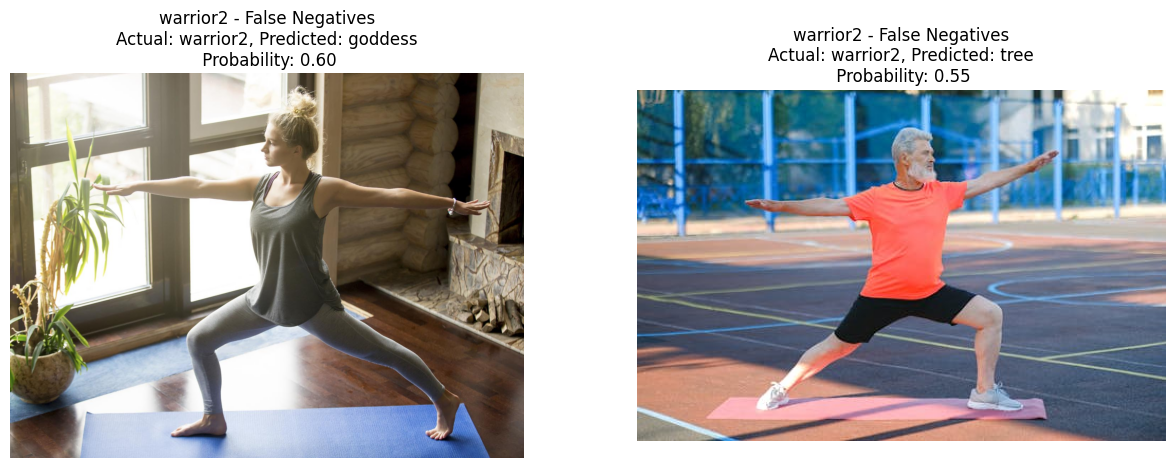

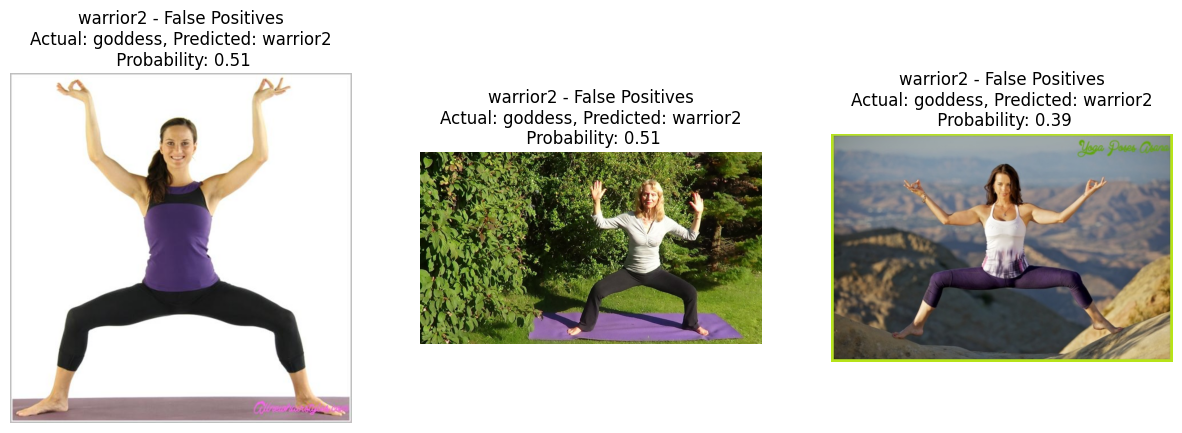

In [37]:
def display_images(image_paths, title_prefix):
    plt.figure(figsize=(15, 5))
    for i, (image_path, actual, predicted, max_prob) in enumerate(image_paths):
        image = Image.open(image_path)
        plt.subplot(1, len(image_paths), i + 1)
        plt.imshow(image)
        plt.axis("off")
        plt.title(
            f"{title_prefix}\nActual: {actual}, Predicted: {predicted}\n Probability: {max_prob:.2f}"
        )
    plt.show()


for class_name in class_names:
    print(f"Class: {class_name}")
    if false_negatives[class_name]:
        display_images(
            false_negatives[class_name],
            title_prefix=f"{class_name} - False Negatives",
        )
    if false_positives[class_name]:
        display_images(
            false_positives[class_name],
            title_prefix=f"{class_name} - False Positives",
        )


In [38]:
from torchmetrics import Precision

precision_fn = Precision(
    num_classes=len(class_names), task="multiclass", average="macro"
)
precision = precision_fn(preds=y_pred_tensor, target=target_tensor)
print(precision)

tensor(0.9761)


In [39]:
from torchmetrics import Recall

recall_fn = Recall(num_classes=len(class_names), task="multiclass", average="macro")
recall = recall_fn(preds=y_pred_tensor, target=target_tensor)
print(recall)

tensor(0.9760)


In [40]:
from torchmetrics import F1Score

f1score_fn = F1Score(num_classes=len(class_names), task="multiclass", average="macro")
f1score = f1score_fn(preds=y_pred_tensor, target=target_tensor)
print(f1score)

tensor(0.9760)


In [41]:
torch.cuda.empty_cache()

In [42]:
# import matplotlib.pyplot as plt
# from PIL import Image

# # Plot wrong predictions
# plt.figure(figsize=(15, 15))
# for i, (image_path, true_label, pred_label) in enumerate(wrong_preds):
#     plt.subplot(
#         5, 5, i + 1
#     )  # Adjust the subplot grid size based on the number of wrong predictions
#     img = Image.open(image_path)
#     plt.imshow(img)
#     plt.title(
#         f"True: {class_names[true_label.item()]}\nPred: {class_names[pred_label.item()]}"
#     )
#     plt.axis("off")
#     if i == 24:  # Display a maximum of 25 wrong predictions
#         break
# plt.tight_layout()
# plt.show()